In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from gensim.models import LdaModel
import pandas as pd

In [2]:
nTopics = 25

In [3]:
# Define topic names
# Define topic names
topic_names = [
    'Precip Variability & Extremes',
    'Hydrogeochemistry',
    'Uncertainty',
    'Soil Moisture',
    'Statistical Hydrology',
    'Rainfall-Runoff',
    'Precipitation Observation',
    'Modeling & Calibration',
    'Water Management',
    'Snow Hydrology',
    'Streamflow Processes',
    'Water Quality',
    'Channel Flow',
    'Floods',
    'Sediment & Erosion',
    'Climate Change',
    'Subsurface Flow & Transport',
    'Scaling & Spatial Varaibility',
    'Land Surface Fluxes',
    'Hydrogeology',
    'Human Interventions & Effects',
    'Land Cover',
    'Systems Hydrology',
    'Modeling & Forecasting',
    'Groundwater'
]

In [4]:
# Define colors to associate with each topic
custom_colors = {
 'burlywood': '#DEB887',
 'chocolate': '#D2691E',
 'crimson': '#DC143C',
 'darkgreen': '#006400',
 'darkorange': '#FF8C00',
 'darkslategrey': '#2F4F4F',
 'deepskyblue': '#00BFFF',
 'dimgray': '#696969',
 'firebrick': '#B22222',
 'gold': '#FFD700',
 'goldenrod': '#DAA520',
 'lawngreen': '#7CFC00',
 'lightcoral': '#F08080',
 'lightpink': '#FFB6C1',
 'mediumvioletred': '#C71585',
 'orangered': '#FF4500',
 'orchid': '#DA70D6',
 'royalblue': '#4169E1',
 'slateblue': '#6A5ACD',
 'springgreen': '#00FF7F',
 'steelblue': '#4682B4',
 'teal': '#008080',
 'turquoise': '#40E0D0',
 'yellow': '#FFFF00',
 'blueviolet': '#8A2BE2',
 'yellowgreen': '#9ACD32'}

# turn into a list
colorlist = []
for i, color in enumerate(custom_colors.values()):
    colorlist.append(tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)))
    colorlist[i] = (colorlist[i][0] / 256, colorlist[i][1] / 256, colorlist[i][2] / 256)

# Load Data

In [5]:
# Load model
lda_model = LdaModel.load(f'trained_models/trained_lda_model_{nTopics}')

In [6]:
# Load topic distributions
topic_distributions = np.load(f'data/topic_distributions_{lda_model.num_topics}.npy')

In [7]:
# Pull topics
topics = lda_model.show_topics(formatted=False, num_topics=nTopics, num_words=20)

In [8]:
# load raw corpus dataframe
with open('data/raw_corpus.pkl', 'rb') as f:
    corpus_df = pkl.load(f)

In [9]:
# Pull journals
journals = corpus_df.Journal.unique()
journals

array(['HESS', 'HP', 'HSJ', 'JH', 'JHM', 'WRR'], dtype=object)

In [10]:
# Pull years
years = np.unique(corpus_df['Year'])

# Corpus Complexity

In [11]:
def calc_entropy(pmf):
    return -np.nansum(pmf * np.log(pmf)) #code implementation of entropy equation

In [12]:
# Count per journal per year
journal_papers = np.full(len(journals), np.nan) #an array of nans with a len(journal)=6
for j, journal in enumerate(journals): #count for all journals
    journal_papers[j] = len(np.where(corpus_df['Journal'] == journal)[0]) #length of array of wherever the journal is true for a year 

In [13]:
# eqn. 4
# calculate total entropy per journal
journal_entropy = np.full(len(journals), np.nan) 
journal_topic_popularity = np.full([len(journals), nTopics], np.nan) 
for j, journal in enumerate(journals): 
    jidx = np.where(corpus_df.Journal == journal)[0]      
    a = np.sum(topic_distributions[jidx,:], axis=0)
    b = np.sum(topic_distributions[jidx,:]) 
    journal_topic_popularity[j,:] = a/b  
    journal_entropy[j] = calc_entropy(journal_topic_popularity[j,:])

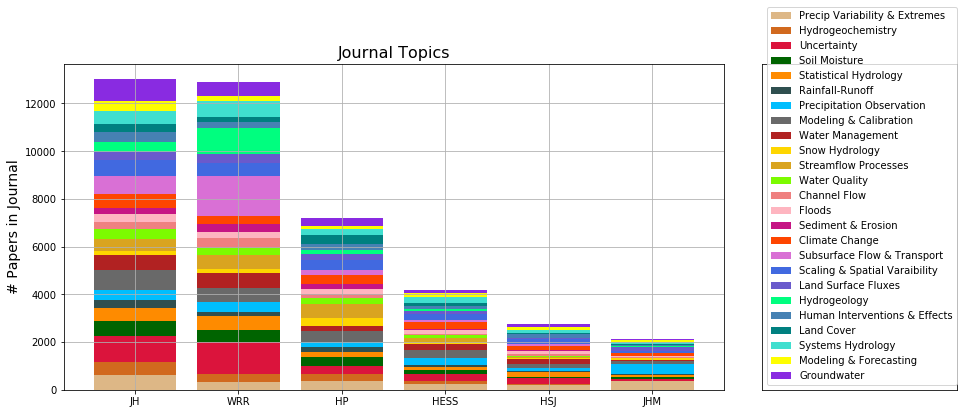

In [14]:
# plot total entropy per journal
fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(1,4)

sort_dex = np.argsort(-journal_papers)
plotdata = journal_topic_popularity * np.expand_dims(journal_papers,-1)

ax1 = fig.add_subplot(gs[0, :3])
for t in range(nTopics):
    if t == 0:
        ax1.bar(journals[sort_dex], plotdata[sort_dex, t],
               color=colorlist[t])
    else:
        ax1.bar(journals[sort_dex], plotdata[sort_dex, t],
               bottom=np.sum(plotdata[sort_dex, :t], axis=1),
               color=colorlist[t])

ax1.set_ylabel('# Papers in Journal', fontsize=14)
ax1.set_title(f'Journal Topics', fontsize=16)
ax1.grid()


ax0 = fig.add_subplot(gs[0, 3])
for t in range(nTopics):
    if t == 0:
        ax0.bar(journals[sort_dex], plotdata[sort_dex, t],
               color=colorlist[t])
    else:
        ax0.bar(journals[sort_dex], plotdata[sort_dex, t],
               bottom=np.sum(plotdata[sort_dex, :t], axis=1),
               color=colorlist[t])
ax0.legend(topic_names)
ax0.bar(journals[sort_dex], np.sum(plotdata[sort_dex, :], axis=1), color='w')
ax0.set_xticks([])
ax0.set_yticks([])

# Save figure
plt.savefig('figures/journal_topics_papers.png')

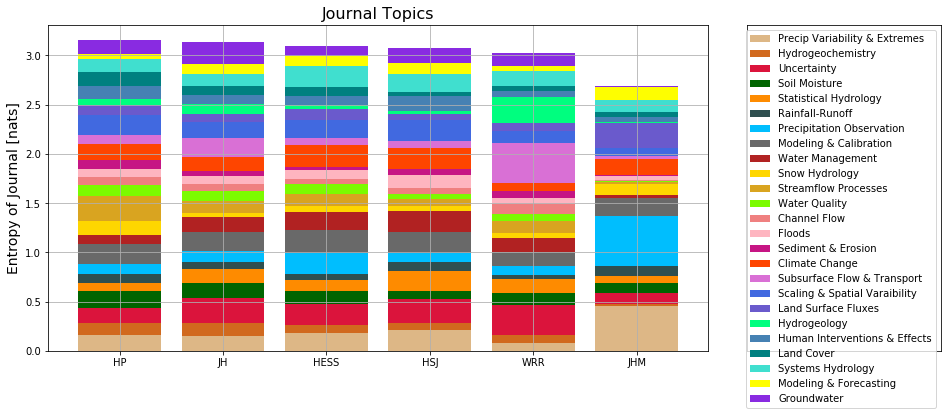

In [15]:
# plot total entropy per journal
fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(1,4)

sort_dex = np.argsort(-journal_entropy)
plotdata = journal_topic_popularity * np.expand_dims(journal_entropy,-1)
# plotdata = -journal_topic_popularity * np.log(journal_topic_popularity)

ax1 = fig.add_subplot(gs[0, :3])
for t in range(nTopics):
    if t == 0:
        ax1.bar(journals[sort_dex], plotdata[sort_dex, t],
               color=colorlist[t])
    else:
        ax1.bar(journals[sort_dex], plotdata[sort_dex, t],
               bottom=np.sum(plotdata[sort_dex, :t], axis=1),
               color=colorlist[t])

ax1.set_ylabel('Entropy of Journal [nats]', fontsize=14)
ax1.set_title(f'Journal Topics', fontsize=16)
ax1.grid()


ax0 = fig.add_subplot(gs[0, 3])
for t in range(nTopics):
    if t == 0:
        ax0.bar(journals[sort_dex], plotdata[sort_dex, t],
               color=colorlist[t])
    else:
        ax0.bar(journals[sort_dex], plotdata[sort_dex, t],
               bottom=np.sum(plotdata[sort_dex, :t], axis=1),
               color=colorlist[t])
ax0.legend(topic_names)
ax0.bar(journals[sort_dex], np.sum(plotdata[sort_dex, :], axis=1), color='w')
ax0.set_xticks([])
ax0.set_yticks([])

# Save figure
plt.savefig('figures/journal_topics_entropy.png')

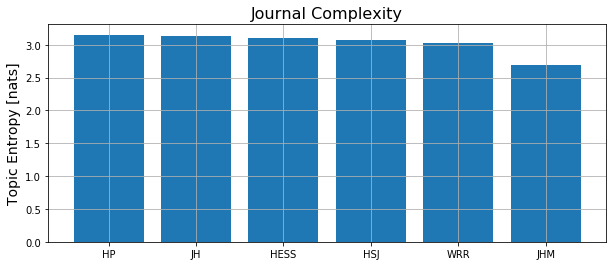

In [16]:
# plot total entropy per journal
fig, ax = plt.subplots(figsize=(10,4))
sort_dex = np.argsort(-journal_entropy)
plt.bar(journals[sort_dex], journal_entropy[sort_dex])
plt.ylabel('Topic Entropy [nats]', fontsize=14)
plt.title(f'Journal Complexity', fontsize=16)
# plt.ylim([2,3])
plt.grid()
plt.savefig('figures/journal_entropy.png')

In [17]:
# calculate entropy of whole corpus
corpus_entropy = np.full(len(years), np.nan)
topic_popularity = np.full([len(years),nTopics], np.nan)
for y, year in enumerate(years):
    topic_distributions_year = topic_distributions[corpus_df['Year'] == year,:]
    topic_popularity[y,:] = np.sum(topic_distributions_year, axis=0) / np.sum(topic_distributions_year)
    corpus_entropy[y] = calc_entropy(topic_popularity[y])

In [18]:
# calculate entropy of individual journals
journal_year_entropy = np.full([len(journals), len(years)], np.nan)
journal_year_topic_popularity = np.full([len(journals), len(years), nTopics], np.nan)
for y, year in enumerate(years):
    for j, journal in enumerate(journals):
        jyidx = np.where(np.logical_and((corpus_df.Journal == journal), (corpus_df.Year == year)))[0]        
        journal_year_topic_popularity[j,y,:] = np.sum(topic_distributions[jyidx,:], axis=0) / np.sum(topic_distributions[jyidx,:]) #per year per topic distribution/ per year all topic distribution
        journal_year_entropy[j,y] = calc_entropy(journal_year_topic_popularity[j,y,:])

/home/mashrekur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


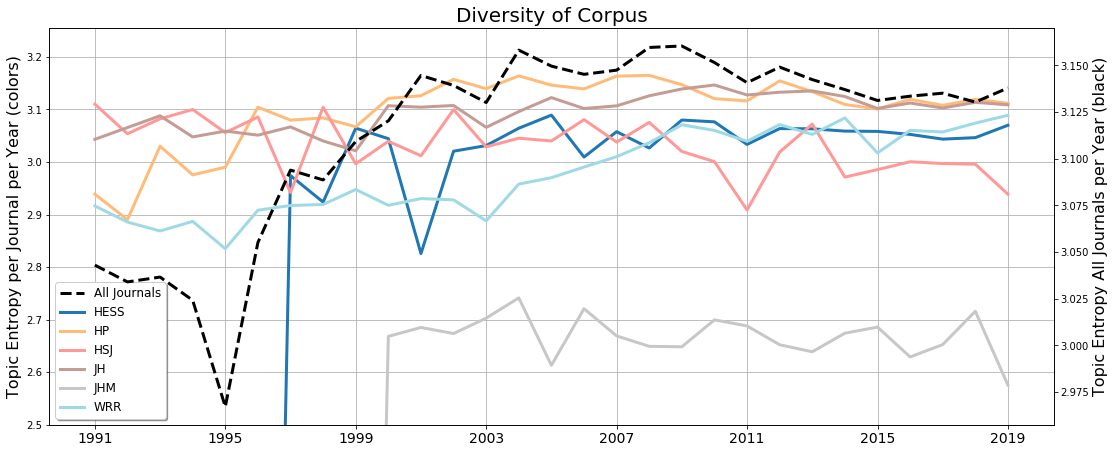

In [26]:
# Create corpus figure --- by year

# Init figures
fig, ax = plt.subplots(figsize=(18,7.3))

# set color cycle
colordexes = np.linspace(0,19,len(journals)).astype(int)
colors = list(plt.cm.tab20(np.arange(20)))
colors = [colors[i] for i in colordexes]
ax.set_prop_cycle('color', colors)

# Plot full corpus count by year
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
lines = ax2.plot(years, corpus_entropy, 
                 'k--', 
                 label=f'All Journals', 
                 linewidth = 3)  

# Plot each journal individually
for j, journal in enumerate(journals):
    linej = ax.plot(years, journal_year_entropy[j,:], 
                       linewidth = 3,
                       label=f'{journal}')
    lines = lines+linej
    
# Axis labels
ax.set_title(f'Diversity of Corpus', fontsize=20)
ax.set_ylabel('Topic Entropy per Journal per Year (colors)', fontsize=16)
ax2.set_ylabel('Topic Entropy All Journals per Year (black)', fontsize=16)
ax.set_xticks(years[np.floor(np.linspace(0,len(years)-1,8)).astype(int)])
ax.set_xticklabels(years[np.floor(np.linspace(0,len(years)-1,8)).astype(int)], fontsize=14)
ax.set_ylim([2.5,3.255])

# Legend
labs = [l.get_label() for l in lines]
ax.legend(lines, labs, fontsize=12, shadow=True, loc=3)

# Aesthetics    
ax.grid()

# Save figure
plt.savefig('figures/corpus_entropy.png')

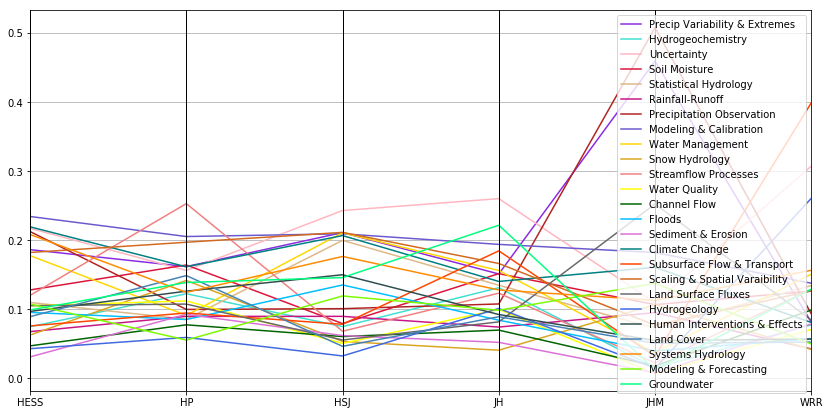

<Figure size 432x288 with 0 Axes>

In [27]:
#parallel coordinates plot

#create dataframe of index, columns and data
df_plotdata = pd.DataFrame(index = topic_names, columns = journals, data = np.transpose(plotdata))
df_plotdata.index.name = "topics"
df_plotdata = df_plotdata.reset_index()

#plot figure
fig = plt.figure(figsize=(14,7))
gs = fig.add_gridspec(1,4)
pd.plotting.parallel_coordinates(df_plotdata, "topics", color = list(custom_colors.values())[0:25], 
                                axvlines = 'Yes', sort_labels = 'Yes')
plt.show()
# Save figure
plt.savefig('figures/parallel_coordinate_entropy.png')

# Journal Uniqueness

In [ ]:
def calc_KL_divergence(pmf1,pmf2):
    return -np.nansum(pmf1 * np.log(pmf2/pmf1))

In [ ]:
def jensen_shannon_distance(pmf1,pmf2):
    M=0.5*(pmf1+pmf2)
    D1=calc_KL_divergence(pmf1,M)
    D2=calc_KL_divergence(pmf2,M)
    JSDiv = 0.5*D1+0.5*D2
    JSD = np.sqrt(JSDiv)
    return JSD

In [ ]:
# calculate JSD 
JSD_journals = np.full([len(journals), len(years)], np.nan)
for y, year in enumerate(years):
    for j, journal in enumerate(journals):
        JSD_journals[j,y] = jensen_shannon_distance(journal_year_topic_popularity[j,y,:],
                                                     topic_popularity[y,:])

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,5))

# set color cycle
colordexes = np.linspace(0,19,len(journals)).astype(int)
colors = list(plt.cm.tab20(np.arange(20)))
colors = [colors[i] for i in colordexes]

plotdata = JSD_journals.transpose()
plotdata[plotdata==0] = np.nan

ax.set_prop_cycle('color', colors)
ax.plot(years, plotdata, lw=3)

# aesthetics
ax.legend(journals, shadow=True)
ax.set_title(f'Uniqueness of Journals', fontsize=20)
ax.set_ylabel('Distance from Journal to Corpus', fontsize=16)
ax.set_xticks(years[np.floor(np.linspace(0,len(years)-1,8)).astype(int)])
ax.set_xticklabels(years[np.floor(np.linspace(0,len(years)-1,8)).astype(int)], fontsize=14)
plt.grid()

# Save figure
plt.savefig('figures/journal_uniqueness.png')

# Journal Diversity

In [ ]:
# calculate JSD 
JSD_across_journals = np.full([len(journals), len(journals), len(years)], np.nan)
for y, year in enumerate(years):
    for j1, journal1 in enumerate(journals):
        for j2, journal2 in enumerate(journals):
            JSD_across_journals[j1,j2,y] = jensen_shannon_distance(journal_year_topic_popularity[j1,y,:],
                                                                   journal_year_topic_popularity[j2,y,:])

In [ ]:
# plot JSD for each journal 
fig, axes = plt.subplots(3,2,figsize=(40,30))

# set color cycle
colordexes = np.linspace(0,19,len(journals)).astype(int)
colors = list(plt.cm.tab20(np.arange(20)))
colors = [colors[i] for i in colordexes]

for i, ax in enumerate(axes.flatten()):
    if i < len(journals):
        ax.set_prop_cycle('color', colors)
        plotdata = JSD_across_journals[i,:,:].transpose()
        plotdata[plotdata==0] = np.nan
        ax.plot(np.sort(years), JSD_across_journals[i,:,:].transpose(), linewidth=3)
        ax.set_title(journals[i], fontsize=24)
        ax.set_ylim([0.0, 0.8])
        ax.set_xlim([0, 27])
        ax.set_xticks(np.floor(np.linspace(0,len(years)-1,5)))
        ax.legend(journals)
        ax.grid() 
        
# Save figure
plt.savefig('figures/journal_time_jsd.png')

In [ ]:
#calculate JSD over whole corpus
JSD_corpus = np.full([len(journals), len(journals)], np.nan)
for j1, journal1 in enumerate(journals):
    for j2, journal2 in enumerate(journals):
        JSD_corpus[j1,j2] = jensen_shannon_distance(journal_year_topic_popularity[j1,:],
                                                    journal_year_topic_popularity[j2,:])

In [ ]:
#plot single confusion matrix over

fig, ax = plt.subplots(1,1, figsize=(7,7))

plot_data = JSD_corpus
plot_data[plot_data == 0] = np.nan
conf_arr_corpus = np.array(plot_data)    
res = ax.imshow(np.array(conf_arr_corpus), cmap="YlGnBu", interpolation='nearest')
width = len(journals)
height = len(journals)
ax.set_xticks(range(width))
ax.set_yticks(range(height))
ax.set_xticklabels(journals, rotation=90)
ax.set_yticklabels(journals)
ax.set_title('Distance Between Journals', fontsize=14)
cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
fig.colorbar(res, cax=cbar_ax)

# Save figure
plt.savefig('figures/journal_jsd.png')